Introduction to ML - Decision Tree Coursework

In [43]:
import numpy as np

Step 1: Loading Data

In [44]:
# Reading in the datasets
clean_dataset = np.loadtxt('Dataset/clean_dataset.txt')
noisy_dataset = np.loadtxt('Dataset/noisy_dataset.txt')

Step 2: Creating Decision Trees

In [45]:
# Function to calculate entropy
def cal_entropy(dataset):

    nique, counts = np.unique(dataset[:,-1], return_counts=True)

    pk_values = []

    # calculating pk values
    for k in range(len(nique)):
        pk = counts[k]/len(dataset[:, -1])
        pk_values.append(pk)

    entropy = 0
    # calculating entropy based on pk values
    for pk in pk_values:
        entropy += (pk * np.log2(pk))

    return -1 * entropy

In [46]:
# Function to calculate the best split feature and value
# We will iterate through all possible split points and calculate the info gain if we were to use the split point and update to using the best split (highest info gain)
def find_split(dataset):

    # Initialisation
    best_info_gain = -9999
    best_feature_index = None
    best_feature_value = None

    best_left_data = []
    best_right_data = []

    best_value = None

    entropy_complete_dataset = cal_entropy(dataset)

    # Loop through all features
    for feature_index in range(dataset.shape[1]-1):
        # Get unique feature values
        unique_feature_values = np.unique(dataset[:,feature_index])

        # Find all potential split points (midpoint between the values)
        potential_splits = []

        for i in range(len(unique_feature_values)-1):
            current_value = unique_feature_values[i]
            next_value = unique_feature_values[i+1]

            mid_value = (current_value+next_value)/2

            potential_splits.append(mid_value)

        # For every value in the potential splits, we calculate left and right datasets
        # we also calculate the information gain
        # we keep track of the best split value and attribute, along with the best left and right datasets
        for split_value in potential_splits:
            left_dataset_list = []
            right_dataset_list = []

            for row in dataset:
                if row[feature_index] <= split_value:
                    left_dataset_list.append(row)
                else:
                    right_dataset_list.append(row)
            
            # Initialising the new split datasets
            left_dataset = np.array(left_dataset_list)
            right_dataset = np.array(right_dataset_list)

            # Calculating the probabilities of new split datasets
            prob_left = len(left_dataset) / len(dataset)
            prob_right = len(right_dataset) / len(dataset)

            # Finding information gain based on the split
            information_gain = entropy_complete_dataset - (prob_left * cal_entropy(left_dataset) + (prob_right * cal_entropy(right_dataset)))
 
            # Checking in information gain on this split is better than the previous best
            if information_gain > best_info_gain:
                best_info_gain = information_gain
                best_feature_index = feature_index
                
                best_left_data = left_dataset
                best_right_data = right_dataset

                best_value = split_value

    return best_info_gain, best_feature_index, best_value, best_left_data, best_right_data

In [47]:
class Node:
  def __init__(self, left = None, right = None, split_value = None, attribute_index = None,
   prediction = None, majority_class = None) -> None:
    """
    Represents a node in a decision tree
    
    Has 'left' and 'right' values which point to different nodes
    The split value and attribute index mentions what value and which attribute index we are going to be splitting on
    If the node is a leaf, 'is_leaf' would return 'True' and 'prediction' would return the prediction for that node
    When 'prune()' is invoked the node becomes a leaf and 'majority_class' is used to determine the the 'prediction'
    """
    self.left = left
    self.right = right
    self.split_value = split_value
    self.attribute_index = attribute_index
    self.prediction = prediction
    self.majority_class = majority_class

    self.x = 0.0

  @property
  def is_leaf(self) -> bool:
    # A node is a leaf if it has no left or right child
    return self.left is None and self.right is None

  def prune(self):
    """
    Turns this node into a leaf node by removing its children
    and setting its prediction to its majority_class
    """
    # Set the prediction to the stored majority class
    self.prediction = self.majority_class 
    
    # Remove children (this will make .is_leaf automatically return True)
    self.left = None
    self.right = None

    # Clear the split info since no longer relevant
    self.split_value = None
    self.attribute_index = None

In [48]:
def decision_tree_learning(dataset, depth=0):

     # if the data has all the same values, then we have a leaf node
    unique_labels = np.unique(dataset[:,-1])
    if len(unique_labels)==1:
        leafNode = Node(prediction=unique_labels[0])
        return leafNode, depth

    # otherwise, we get the best values for split, and create a new node
    best_info_gain, best_feature_index, best_value, left_data, right_data = find_split(dataset)

    # Find the majority class of the current training data subset (used in pruning phase)
    nique, counts = np.unique(dataset[:,-1], return_counts=True)
    majority_label_for_this_node = nique[np.argmax(counts)]
    
    # Best feature index 
    # best info gain
    # best feature value
    node = Node(split_value=best_value,
                attribute_index=best_feature_index,
                majority_class=majority_label_for_this_node)
    
    node.left, l_depth = decision_tree_learning(left_data, depth + 1)
    node.right, r_depth = decision_tree_learning(right_data, depth + 1)

    return (node, max(l_depth, r_depth))

Tree Visualisation  

*Taken Inspiration from the Reingold-Tilford Algorithm*

In [159]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# For visualisation, we first traverse through all the leafs and assign it a x-coordinate. Next, we traverse again and assign coordinates for the parent using the coordinates of the leaf. Finally, we draw the tree using a top down approach once we have all the required coordinates.

# Assigning x-coordinates for all the leafs, we traverse the tree using post order tree traversal to assign all coordinates
def assign_leaf_x_coords(node, current_count):
    #Recursing left
    if node.left:
        current_count = assign_leaf_x_coords(node.left, current_count)
    #Recursing right
    if node.right:
        current_count = assign_leaf_x_coords(node.right, current_count)
    #Check if leaf and assign coordinate
    if node.is_leaf:
        # This is a leaf so we assign it the next x-coordinate using the counter
        node.x = current_count
        current_count = current_count+1
    
    return current_count
    
# Next for each parent node we assign x-coordinates by calculating midpoint, used post order traversal again.
def assign_parent_x_coords(node):
    if node.is_leaf:
        # A leaf's x is already set. It is its own leftmost and rightmost point.
        return node.x, node.x
    else:
        left_min, left_max = 0.0, 0.0
        right_min, right_max = 0.0, 0.0
        
        if node.left:
            left_min, left_max = assign_parent_x_coords(node.left)
        
        if node.right:
            right_min, right_max = assign_parent_x_coords(node.right)
        
        
        if node.left and node.right:
            # Center between the two children
            node.x = (node.left.x + node.right.x) / 2
        elif node.left:
            # Align with the single left child
            node.x = node.left.x
        elif node.right:
            # Align with the single right child
            node.x = node.right.x
        
        # Return the min and max x-span of the subtree
        if node.left and node.right:
            return left_min, right_max
        elif node.left:
            return left_min, left_max
        elif node.right:
            return right_min, right_max
        else:
            return node.x, node.x

def draw_recursive(ax, node, depth, max_depth):
    # We print the nodes using a top down approach using a pre order traversal
    # Calculate y-coordinate from depth (root is at top)
    y = max_depth - depth
    
    # Box formatting
    box_style = dict(boxstyle='round,pad=0.5', fc='w', lw=2)
    fontsize = 16

    if node.is_leaf:
        node_text = f"{node.prediction:.1f}" 
        box_style['ec'] = 'g' # Green box for leaves
        ax.text(node.x, y, node_text, ha='center', va='center', bbox=box_style, color='g', fontsize=fontsize, fontweight='bold')
    else:
        node_text = f"[X{node.attribute_index} < {node.split_value:.1f}]"
        box_style['ec'] = 'b' # Blue box for decisions
        ax.text(node.x, y, node_text, ha='center', va='center', bbox=box_style, color='b', fontsize=fontsize, fontweight='bold')
        
        # Draw branches to children
        y_child = y - 1
        if node.left:
            ax.plot([node.x, node.left.x], [y, y_child], 'k-') # Black line
            draw_recursive(ax, node.left, depth + 1, max_depth)
        
        if node.right:
            ax.plot([node.x, node.right.x], [y, y_child], 'k-') # Black line
            draw_recursive(ax, node.right, depth + 1, max_depth)

def visualize_tree(tree, title="Decision Tree Visualisation"):

    # Extracting root and depth
    root_node = tree[0]
    max_depth = tree[1]
    
    # Initialising the variable that will keep track of the number of leaves
    current_count = 0
    # Counting total number of leaves
    total_leaves = assign_leaf_x_coords(root_node,current_count) 
    assign_parent_x_coords(root_node) 
    
    # Setting up the plot 
    fig_width = max(15, total_leaves * 0.9)
    fig_height = max(8, max_depth * 1.6)
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    fig.suptitle(title, fontsize=16)
    ax.axis('off')
    
    ax.set_xlim(-1, total_leaves)
    ax.set_ylim(-1, max_depth + 1)

    # Adding Legend
    leaf_patch = Patch(color='g', label='Leaf Node')
    inner_patch = Patch(color='b', label='Inner Node')
    ax.legend(handles=[leaf_patch, inner_patch], loc='upper left', fontsize=30)
    draw_recursive(ax, root_node, 0, max_depth)
    
    # Display the plot
    plt.tight_layout()
    plt.show()





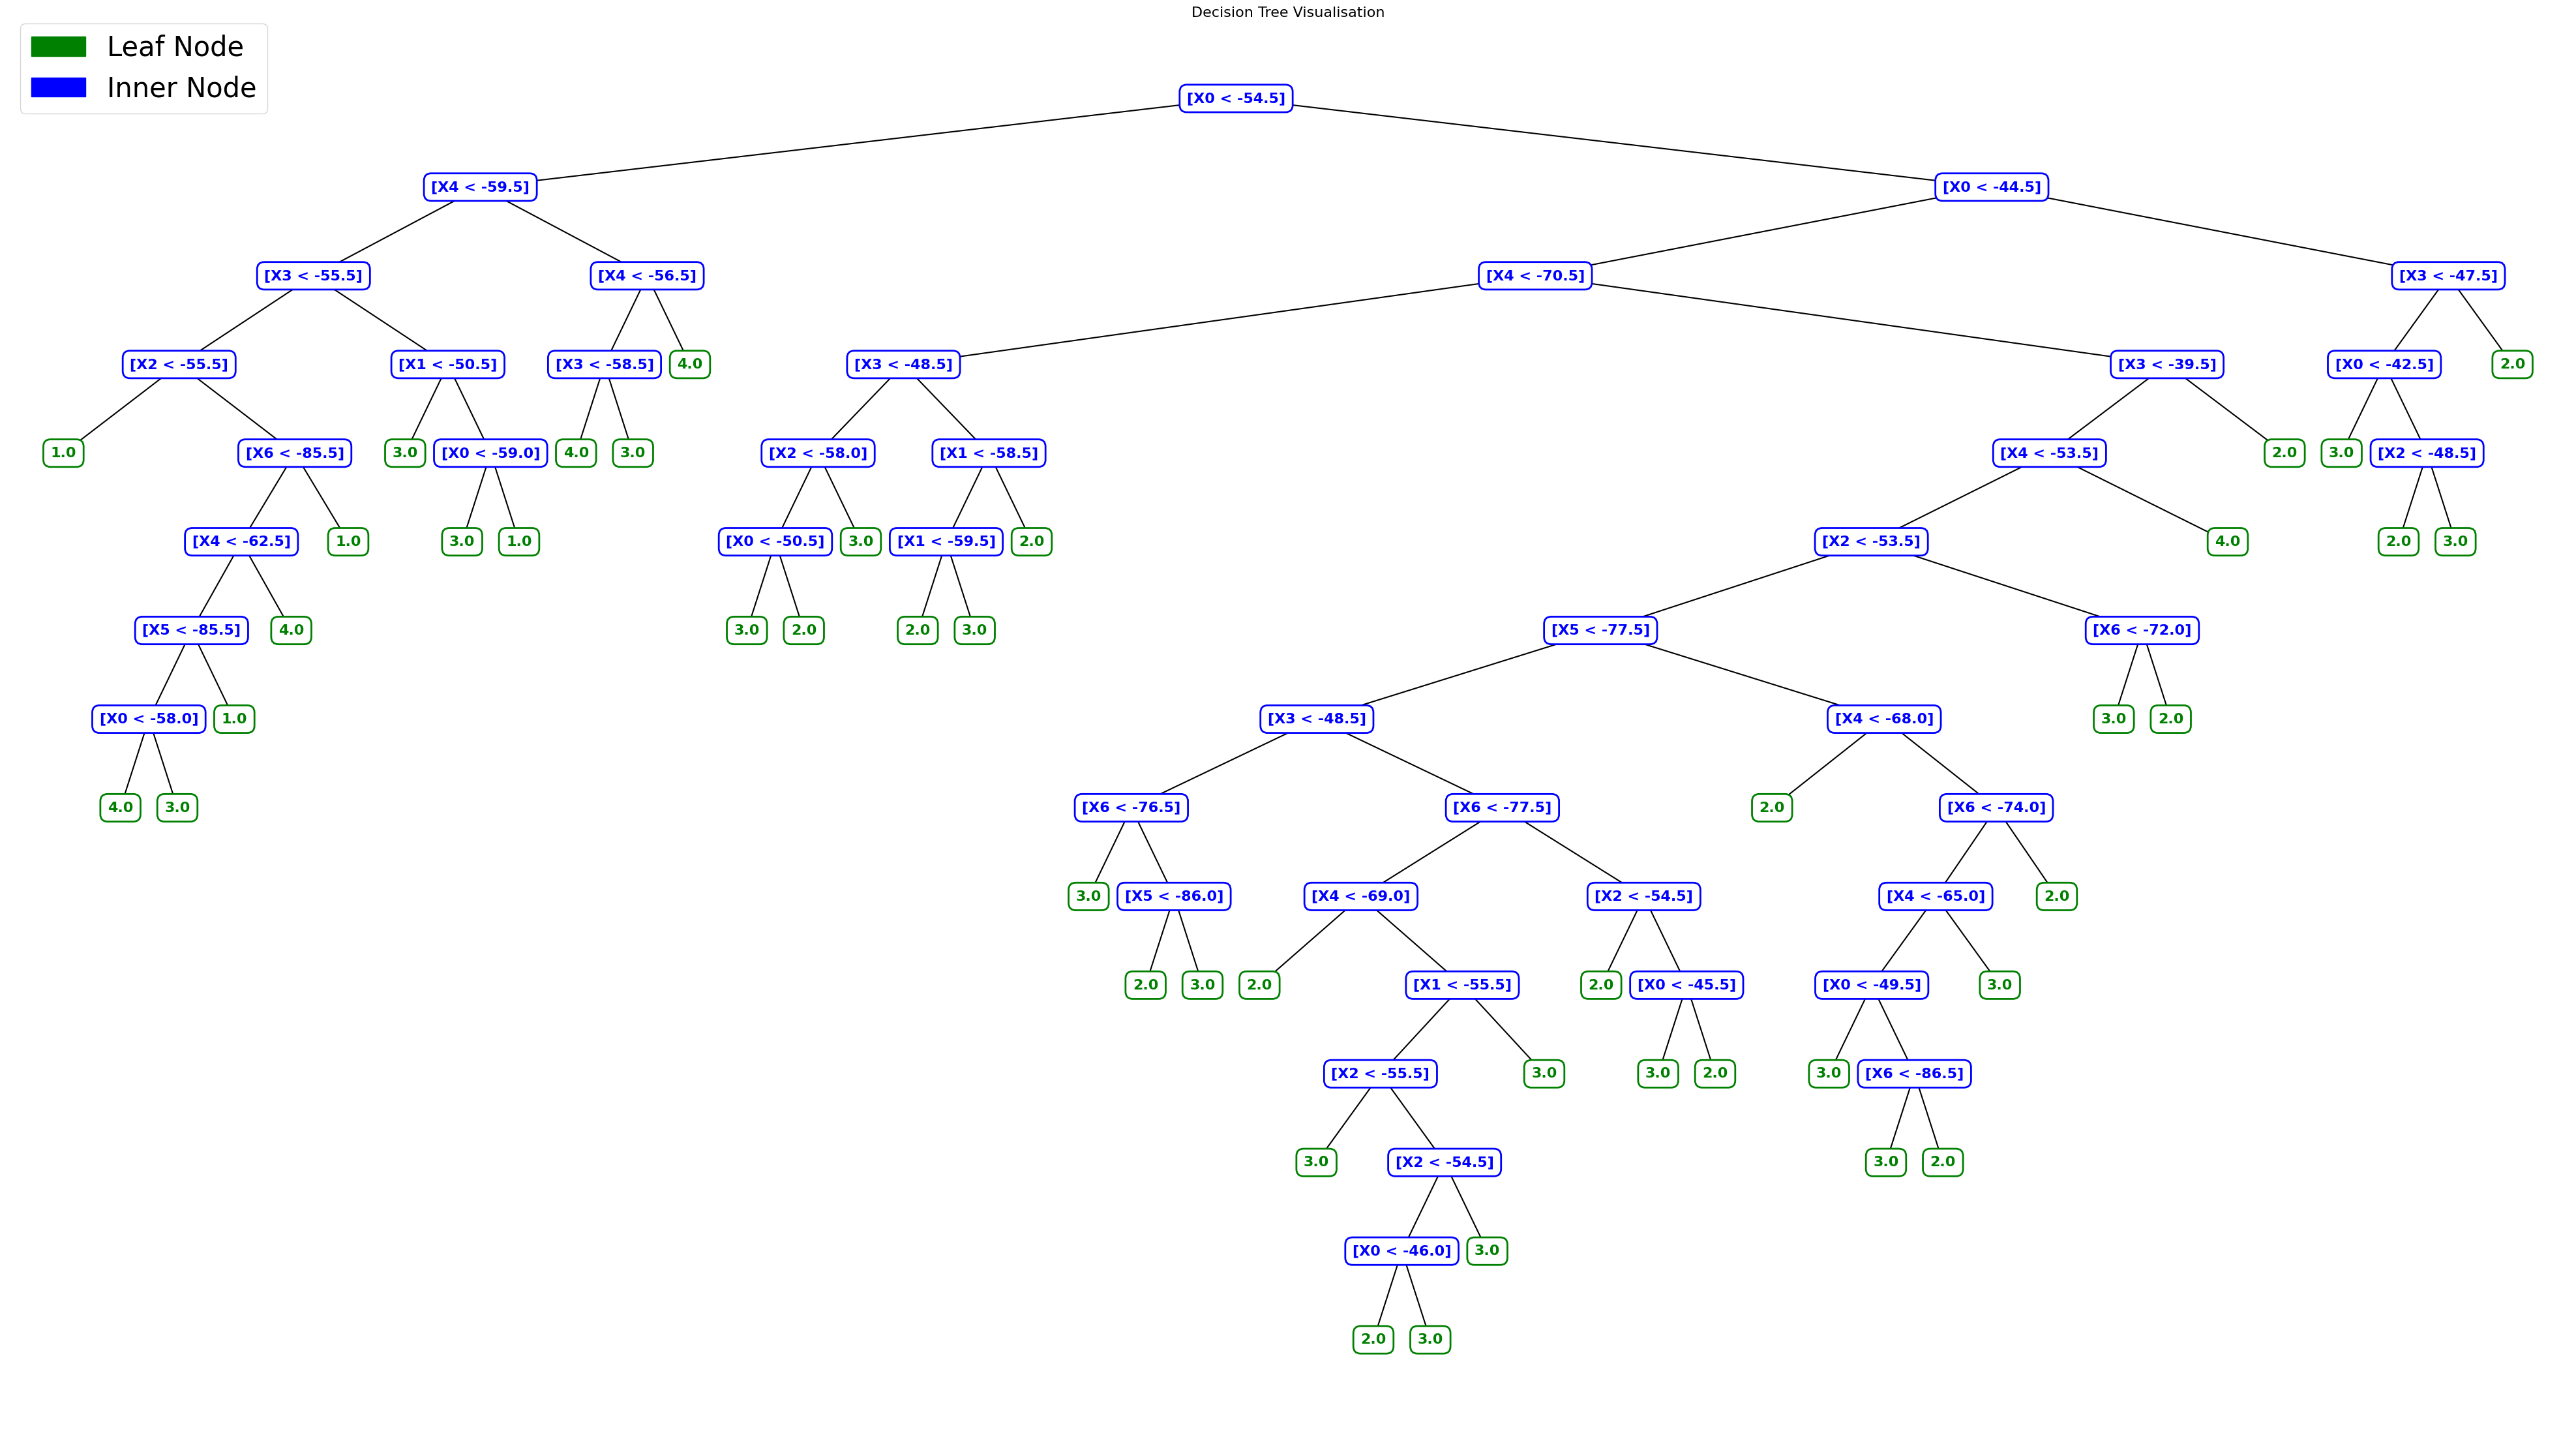

In [158]:
clean_tree = decision_tree_learning(clean_dataset)
visualize_tree(clean_tree)

In [ ]:
def kfold_datasets_generator(dataset, number_of_folds=10):
    """
    Simply devides the dataset into k folds with 10 being the default value
    """

    working_data = dataset.copy()
    np.random.shuffle(working_data)
    split_datasets = np.split(working_data, number_of_folds)

    return split_datasets

In [15]:
def get_prediction(node: Node, input):

    # given an input of size (1, 8), we follow the decision tree, and return the final predicted value
    val = node.split_value
    index = node.attribute_index
    if node.is_leaf:
        return node.prediction
    if input[index] <= val:
        return get_prediction(node.left, input)
    else:
        return get_prediction(node.right, input)

In [ ]:
def evaluate_tree_performance(tree, test_set):
    """
    This function evaluates a single tree on a test set
    and returns the confusion matrix
    """

    # Create a confusion matrix just for this single fold
    confusion_matrix = np.zeros((4, 4), dtype=int)

    # for every row in the testing data, we get a predicted and actual value
    for row in test_set:
        predicted = get_prediction(tree, row)
        actual = row[-1]
        predicted = predicted.astype(np.int64)
        actual = actual.astype(np.int64)
        
        # -1 because classes are 1-4 but indices are 0-3
        confusion_matrix[predicted - 1][actual - 1] += 1
            
    return confusion_matrix

In [102]:
def get_tree_depth(node):
    """
    Recursively calculates the  depth of a given tree
    """
    # A leaf has depth 0
    if node.is_leaf:
        return 0
    
    # Recursively find depth of children
    left_depth = 0
    if node.left:
        left_depth = get_tree_depth(node.left)
        
    right_depth = 0
    if node.right:
        right_depth = get_tree_depth(node.right)
        
    # Depth is 1 + the deeper of its two children
    return 1 + max(left_depth, right_depth)

In [ ]:
def kfold_evaluator(all_folds, prune = False):
    num_of_folds = len(all_folds)

    # Initialize one total confusion matrix
    # This will accumulate results from all folds.
    total_confusion_matrix = np.zeros((4, 4), dtype=np.int64)

    all_depths = []
    
    for i in range(num_of_folds):
        
        outer_training_folds = all_folds[:i] + all_folds[i+1:]
        test_set = all_folds[i]

        node = None # This will hold the final tree whether we prune or not
        
        if prune:
            num_inner_folds = len(outer_training_folds)

            for j in range(num_inner_folds):
                # Set asside one more fold for us to use as the validation set
                inner_validation_set = outer_training_folds[j]

                # Assemble inner training set with remaining data
                inner_training_folds = outer_training_folds[:j] + outer_training_folds[j+1:]
                inner_training_set = np.concatenate((inner_training_folds), axis=0)

                # Train 
                node, _ = decision_tree_learning(inner_training_set, 0)
                
                # Run pruning
                pruned_tree = prune_tree(node, inner_validation_set)

                # Calculate and store the depth of the pruned tree 
                pruned_depth = get_tree_depth(pruned_tree)
                all_depths.append(pruned_depth)
                
                # Run the evaluation on test data
                inner_fold_confusion_matrix = evaluate_tree_performance(pruned_tree, test_set)
                
                # Store results
                total_confusion_matrix += inner_fold_confusion_matrix
            
        else:
            # Since we will not prune we use the full  training set
            outer_training_set = np.concatenate(outer_training_folds, axis=0)
            
            node, depth = decision_tree_learning(outer_training_set, 0) # 'node' is the unpruned tree
            all_depths.append(depth)
            
            # Run the evaluation on test data
            fold_confusion_matrix = evaluate_tree_performance(node, test_set)
            
            # Add this fold's results to the total matrix
            total_confusion_matrix += fold_confusion_matrix

    # All Folds Complete
    # Now, we derive all of the metrics at once from the single total matrix,
    # as per the spec's hints.

    print("=" * 30)
    print("--- FINAL AGGREGATE RESULTS ---")
    print("Total (Summed) Confusion Matrix:")
    print(total_confusion_matrix)
    print("=" * 30)

    # Statistics Calculation from Total Matrix
    
    print("--- Per-Class Statistics (Derived from Total Matrix) ---")
    
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for k in range(4):
        class_name = f"Class {k+1}"

        # True Positives: Correctly predicted for this class
        true_positives = total_confusion_matrix[k, k]
        
        # False Positives: Predicted as this class, but was actually another
        # Sum of row 'k', minus the TP
        false_positives = np.sum(total_confusion_matrix[k, :]) - true_positives
        
        # False Negatives: Actually this class, but predicted as another
        # Sum of column 'k', minus the TP
        false_negatives = np.sum(total_confusion_matrix[:, k]) - true_positives

        # Precision
        # TP / (TP + FP)
        precision_denominator = (true_positives + false_positives)
        if precision_denominator == 0:
            precision = 0.0
        else:
            precision = true_positives / precision_denominator
        
        precision_scores.append(precision)

        # Recall
        # TP / (TP + FN)
        recall_denominator = (true_positives + false_negatives)
        if recall_denominator == 0:
            recall = 0.0
        else:
            recall = true_positives / recall_denominator
        
        recall_scores.append(recall)

        # F1 Measure
        # 2 * (Precision * Recall) / (Precision + Recall)
        f1_denominator = (precision + recall)
        if f1_denominator == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / f1_denominator
        
        f1_scores.append(f1)

        print(f"{class_name}:")
        print(f"  Precision:       {precision:.4f}")
        print(f"  Recall:          {recall:.4f}")
        print(f"  F1-Measure:      {f1:.4f}")

    print("-" * 30)
    print("--- Overall Statistics (Derived from Total Matrix) ---")
    
    # Overall Accuracy = (Sum of all correct) / (Total samples)
    total_correct = np.trace(total_confusion_matrix) # Sum of the diagonal
    total_samples = np.sum(total_confusion_matrix)
    
    if total_samples == 0:
        overall_accuracy = 0.0
    else:
        overall_accuracy = total_correct / total_samples
        
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    print(f"Average Tree Depth: {np.mean(all_depths):.2f}")
    
    # These are the "Macro Averages" of the per-class scores
    print(f"Macro Average Precision: {np.mean(precision_scores):.4f}")
    print(f"Macro Average Recall: {np.mean(recall_scores):.4f}")
    print(f"Macro Average F1-Measure: {np.mean(f1_scores):.4f}")
    print("=" * 30 + "\n")


In [28]:
datasets = kfold_datasets_generator(clean_dataset)
kfold_evaluator(datasets)

--- FINAL AGGREGATE RESULTS ---
Total (Summed) Confusion Matrix:
[[493   0   2   5]
 [  0 478  19   0]
 [  3  22 477   1]
 [  4   0   2 494]]
--- Per-Class Statistics (Derived from Total Matrix) ---
Class 1:
  Precision:       0.9860
  Recall:          0.9860
  F1-Measure:      0.9860
Class 2:
  Precision:       0.9618
  Recall:          0.9560
  F1-Measure:      0.9589
Class 3:
  Precision:       0.9483
  Recall:          0.9540
  F1-Measure:      0.9511
Class 4:
  Precision:       0.9880
  Recall:          0.9880
  F1-Measure:      0.9880
------------------------------
--- Overall Statistics (Derived from Total Matrix) ---
Overall Accuracy: 0.9710
Macro Average Precision: 0.9710
Macro Average Recall: 0.9710
Macro Average F1-Measure: 0.9710



In [ ]:
datasets = kfold_datasets_generator(noisy_dataset)
kfold_evaluator(datasets)

In [112]:
def find_nodes_to_prune(node, validation_subset):
    """
    Helper function that parses tree to find all nodes that ought to be pruned
    """
    
    def calculate_error_on_subtree(subtree, validation_subset):
        """
        Calculates the total number of errors for a given subtree and dataset
        """
        errors = 0
        # Base case of empty subset
        if validation_subset.size == 0:
            return 0

        for row in validation_subset:
            # Run prediction on the given subtree
            prediction = get_prediction(subtree, row)

            # If prediction does not match label
            if prediction != row[-1]:
                errors += 1

        return errors

    # Leaves should not be pruned by default
    if node.is_leaf:
        return []

    # If both children are leaves we have found a candidate!
    if node.left.is_leaf and node.right.is_leaf:

        # Create pruned node and calculate error on it
        pruned_node = Node(prediction = node.majority_class)
        error_of_pruned = calculate_error_on_subtree(pruned_node, validation_subset)

        # Calculate error on unpruned node
        error_of_unpruned = calculate_error_on_subtree(node, validation_subset)

        if error_of_pruned <= error_of_unpruned:
            return [node] # Choose to prune node
        else:
            return [] # Don't prune

    # --- We split the validation data for the children ---
    left_data_list = []
    right_data_list = []
    
    for row in validation_subset:
        if row[node.attribute_index] <= node.split_value:
            left_data_list.append(row)
        else:
            right_data_list.append(row)

    left_subset = np.array(left_data_list)
    right_subset = np.array(right_data_list)

    # Since this node is not a candidate 
    # we can continue checking it's children
    left_nodes_to_prune = find_nodes_to_prune(node.left, left_subset)
    right_nodes_to_prune = find_nodes_to_prune(node.right, right_subset)

    return left_nodes_to_prune + right_nodes_to_prune

def prune_tree(root_node, validation_set):

    # Call hepler function to get nodes that need to be pruned
    nodes_to_prune_list = find_nodes_to_prune(root_node, validation_set)

    # Loop as long as there are nodes that need to be pruned
    while nodes_to_prune_list:

        # Prune all nodes in the list
        for node in nodes_to_prune_list:
            node.prune()
            
        # Call hepler function again to parse tree again
        nodes_to_prune_list = find_nodes_to_prune(root_node, validation_set)
            
    # Return the pruned tree
    return root_node

    


In [115]:
datasets = kfold_datasets_generator(clean_dataset)
kfold_evaluator(datasets, prune=True)

--- FINAL AGGREGATE RESULTS ---
Total (Summed) Confusion Matrix:
[[494   0   5   4]
 [  0 477  17   0]
 [  6  23 476   5]
 [  0   0   2 491]]
--- Per-Class Statistics (Derived from Total Matrix) ---
Class 1:
  Precision:       0.9821
  Recall:          0.9880
  F1-Measure:      0.9850
Class 2:
  Precision:       0.9656
  Recall:          0.9540
  F1-Measure:      0.9598
Class 3:
  Precision:       0.9333
  Recall:          0.9520
  F1-Measure:      0.9426
Class 4:
  Precision:       0.9959
  Recall:          0.9820
  F1-Measure:      0.9889
------------------------------
--- Overall Statistics (Derived from Total Matrix) ---
Overall Accuracy: 0.9690
Macro Average Precision: 0.9692
Macro Average Recall: 0.9690
Macro Average F1-Measure: 0.9691



In [114]:
datasets = kfold_datasets_generator(noisy_dataset)
kfold_evaluator(datasets, prune=True)

--- FINAL AGGREGATE RESULTS ---
Total (Summed) Confusion Matrix:
[[443  21  21  20]
 [ 12 439  27  16]
 [ 12  27 451  20]
 [ 23  10  16 442]]
--- Per-Class Statistics (Derived from Total Matrix) ---
Class 1:
  Precision:       0.8772
  Recall:          0.9041
  F1-Measure:      0.8905
Class 2:
  Precision:       0.8887
  Recall:          0.8833
  F1-Measure:      0.8860
Class 3:
  Precision:       0.8843
  Recall:          0.8757
  F1-Measure:      0.8800
Class 4:
  Precision:       0.9002
  Recall:          0.8876
  F1-Measure:      0.8938
------------------------------
--- Overall Statistics (Derived from Total Matrix) ---
Overall Accuracy: 0.8875
Macro Average Precision: 0.8876
Macro Average Recall: 0.8877
Macro Average F1-Measure: 0.8876

